<a href="https://colab.research.google.com/github/nalinzip/SCC/blob/main/TID0358.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text(value='KradongEx', description='Project Name:')

Dropdown(description='Focus Team:', index=1, options=('NET ZERO', 'Private Equity', 'Board Director', 'Global …

BoundedIntText(value=5, description='Num Members:', min=1)

Button(description='ใส่กระด้งไหนดีน้า....', style=ButtonStyle())


สมาชิก 5 คนที่เหมาะสมที่สุดในโปรเจกต์ 'KradongEx':
User_153 | Corporate and International Company Secretary (Thailand) | avg score: 8.00
User_34 | Mining Decarbonization (Thailand) | avg score: 7.75
User_97 | Senior Information Technology (Thailand) | avg score: 7.50
User_70 | Corporate Services (Thailand) | avg score: 7.50
User_20 | Economic Intelligence (Thailand) | avg score: 7.00


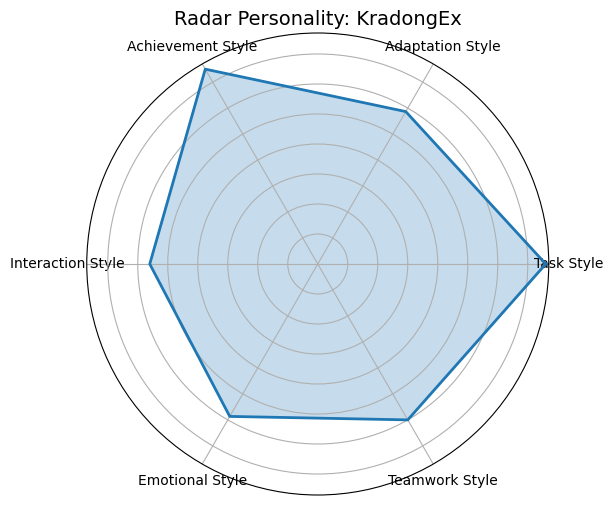


ตัวเลือกสำรอง (5 คน):
User_54 | User Experience and Media Design (Thailand) | avg score: 6.75
User_3 | Low-Code Digitalization (Thailand) | avg score: 6.75
User_145 | Global Internal Audit Group 1 (Thailand) | avg score: 6.50
User_129 | nan (nan) | avg score: 6.50
User_4 | Learning Culture and Innovation Accelerator (Thailand) | avg score: 6.25

พนักงานที่ไม่ผ่านการคัดเลือกในโปรเจกต์ 'KradongEx':
User_76: ไม่ผ่านเพราะ -> Achievement Style ≤ 5.5; Task Style ≤ 5.5; Skill_Investment = 0
User_98: ไม่ผ่านเพราะ -> Achievement Style ≤ 5.5; Task Style ≤ 5.5; Skill_Investment = 0
User_99: ไม่ผ่านเพราะ -> Achievement Style ≤ 5.5; Task Style ≤ 5.5; Skill_Investment = 0
User_67: ไม่ผ่านเพราะ -> Achievement Style ≤ 5.5; Task Style ≤ 5.5; Skill_Investment = 0
User_80: ไม่ผ่านเพราะ -> Achievement Style ≤ 5.5; Task Style ≤ 5.5; Skill_Investment = 0
User_27: ไม่ผ่านเพราะ -> Achievement Style ≤ 5.5; Task Style ≤ 5.5; Skill_Investment = 0
User_93: ไม่ผ่านเพราะ -> Achievement Style ≤ 5.5; Task Style ≤ 5.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

xls = pd.ExcelFile("/content/sample_data/DataSourceBanpu.xlsx")
personality_df = xls.parse('PersonalityTest')
skill_df = xls.parse('Skill')
employee_df = xls.parse('EmployeeData')

personality_df.columns = personality_df.columns.str.strip()
skill_df.columns = skill_df.columns.str.strip()
employee_df.columns = employee_df.columns.str.strip()

categories = {
    "Task Style": ["Drive", "Structure"],
    "Adaptation Style": ["Conceptual", "Flexibility", "Mastery"],
    "Achievement Style": ["Ambition", "Power"],
    "Interaction Style": ["Assertiveness", "Liveliness"],
    "Emotional Style": ["Composure", "Positivity", "Awareness"],
    "Teamwork Style": ["Cooperativeness", "Sensitivity", "Humility"]
}


for style, traits in categories.items():
    personality_df[style] = personality_df[traits].mean(axis=1)

df = personality_df.merge(skill_df, on='Name', how='left')
df = df.merge(employee_df, on='Name', how='left')


skill_keywords = ['Sustainability', 'Decarbonization', 'Finance', 'Investment',
                  'Leadership', 'Strategic', 'Global', 'International', 'Digital', 'Innovation']

for keyword in skill_keywords:
    colname = f'Skill_{keyword}'
    df[colname] = df['Skill'].fillna('').str.contains(keyword, case=False).astype(int)


fit_conditions = {
    'NET ZERO': [('Adaptation Style', 5.5), ('Task Style', 5.5), ('Skill_Sustainability', 1)],
    'Private Equity': [('Achievement Style', 5.5), ('Task Style', 5.5), ('Skill_Investment', 1)],
    'Board Director': [('Emotional Style', 5.5), ('Teamwork Style', 5.5), ('Skill_Leadership', 1)],
    'Global Mindset': [('Adaptation Style', 5.5), ('Interaction Style', 5.5), ('Skill_Global', 1)],
    'Future Capabilities': [('Adaptation Style', 5.5), ('Achievement Style', 5.5), ('Skill_Digital', 1)]
}


for team, conditions in fit_conditions.items():
    level_col = f'Level_{team.replace(" ", "_")}'
    df[level_col] = df.apply(
        lambda row: sum(row[trait] > threshold if 'Style' in trait else row[trait] >= threshold
                        for trait, threshold in conditions),
        axis=1
    )


def explain_non_fit(row, conditions):
    return "; ".join(f"{trait} ≤ {threshold}" if 'Style' in trait else f"{trait} = 0"
                     for trait, threshold in conditions
                     if (row[trait] <= threshold if 'Style' in trait else row[trait] < threshold))

def plot_team_radar(team_df, team_name):
    dimensions = list(categories.keys())
    means = [team_df[dim].mean() for dim in dimensions]
    angles = np.linspace(0, 2 * np.pi, len(dimensions), endpoint=False).tolist()
    means += means[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, means, color='tab:blue', linewidth=2)
    ax.fill(angles, means, color='tab:blue', alpha=0.25)
    ax.set_title(f"Radar Personality: {team_name}", size=14)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(dimensions)
    ax.set_yticklabels([])
    ax.grid(True)
    plt.show()


project_name_input = widgets.Text(value='', description='Project Name:')
team_dropdown = widgets.Dropdown(options=list(fit_conditions.keys()), description='Focus Team:')
member_input = widgets.BoundedIntText(value=5, min=1, max=100, description='Num Members:')
run_button = widgets.Button(description='ใส่กระด้งไหนดีน้า....')

def on_run_click(b):
    clear_output(wait=True)
    display(project_name_input, team_dropdown, member_input, run_button)

    team_name = team_dropdown.value
    project_name = project_name_input.value.strip() or team_name
    num_members = member_input.value

    level_col = f'Level_{team_name.replace(" ", "_")}'
    conditions = fit_conditions[team_name]

    df['score_temp'] = df[[c[0] for c in conditions if 'Style' in c[0]]].mean(axis=1)
    df['sort_score'] = df[level_col] * 10 + df['score_temp']

    selected = df[df[level_col] >= 1].copy()
    top = selected.sort_values('sort_score', ascending=False).head(num_members)
    backup = selected.sort_values('sort_score', ascending=False).iloc[num_members:num_members+5]
    not_selected = df[df[level_col] == 0].copy()

    print(f"\nสมาชิก {num_members} คนที่เหมาะสมที่สุดในโปรเจกต์ '{project_name}':")
    for _, row in top.iterrows():
        print(f"{row['Name']} | {row['Job Title']} ({row['Location']}) | avg score: {row['score_temp']:.2f}")

    plot_team_radar(top, project_name)

    if not backup.empty:
        print(f"\nตัวเลือกสำรอง ({len(backup)} คน):")
        for _, row in backup.iterrows():
            print(f"{row['Name']} | {row['Job Title']} ({row['Location']}) | avg score: {row['score_temp']:.2f}")
    else:
        print("\nไม่มีสมาชิกสำรอง")

    print(f"\nพนักงานที่ไม่ผ่านการคัดเลือกในโปรเจกต์ '{project_name}':")
    for _, row in not_selected.iterrows():
        reasons = explain_non_fit(row, conditions)
        print(f"{row['Name']}: ไม่ผ่านเพราะ -> {reasons}")

    df.drop(columns=['score_temp', 'sort_score'], inplace=True)

run_button.on_click(on_run_click)
display(project_name_input, team_dropdown, member_input, run_button)
